In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, BSpline, splev, splrep, make_interp_spline
import numpy as np
from shapely.geometry import LineString, Point
from shapely.ops import split, snap, linemerge

from core.lanelet_helpers import LaneletHelpers
from core.scenario import Frame, AgentState, Scenario
from lanelet_test_helpers import get_test_map
from core.feature_extraction import FeatureExtractor
from igp2.maneuver import Maneuver, FollowLane, ManeuverConfig
from test_feature_extraction import get_feature_extractor

In [2]:
lanelet_map = get_test_map()
feature_extractor = FeatureExtractor(lanelet_map)
initial_lanelet = feature_extractor.lanelet_map.laneletLayer.get(2)
final_lanelet = feature_extractor.lanelet_map.laneletLayer.get(5)
route = feature_extractor.routing_graph.getRoute(initial_lanelet, final_lanelet)
path = route.shortestPath()

In [3]:
final_point = path[-1].centerline[-1]
points = [(p.x, p.y) for l in path for p in list(l.centerline)[:-1]] \
         + [(final_point.x, final_point.y)]

#points = [(0, 1)] + points
x, y = list(zip(*points))

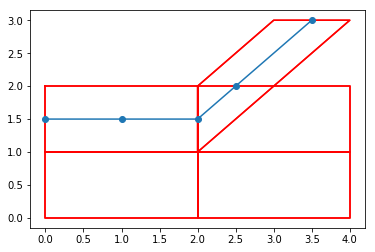

In [4]:
for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)
    
plt.plot(x, y, '-o')

In [5]:
t = np.concatenate(([0], np.cumsum(np.linalg.norm(np.diff(points, axis=0), axis=1))))

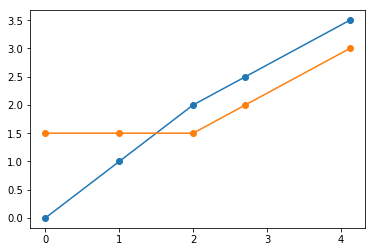

In [6]:
plt.plot(t, x, '-o')
plt.plot(t, y, '-o')

In [7]:
cs_x = CubicSpline(t, x)
cs_y = CubicSpline(t, y)

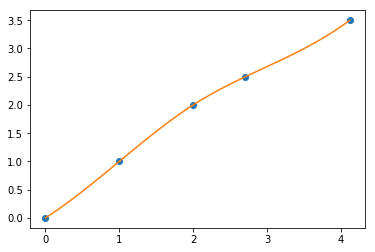

In [8]:
ts = np.linspace(t[0], t[-1])
plt.plot(t, x, 'o')
plt.plot(ts, cs_x(ts))

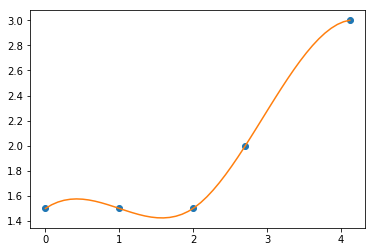

In [9]:
plt.plot(t, y, 'o')
plt.plot(ts, cs_y(ts))

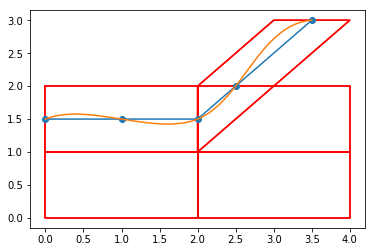

In [10]:
for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(cs_x(ts), cs_y(ts))

In [11]:
cs_x = CubicSpline(t, x, bc_type=((1, 1), (1, 1)))
cs_y = CubicSpline(t, y, bc_type=((1, 0.5), (1, 1)))

In [12]:
points_array = np.array(points)

In [13]:
points_array.shape

(5, 2)

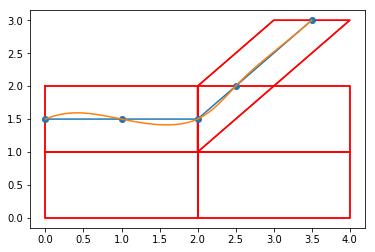

In [14]:
for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(cs_x(ts), cs_y(ts))

In [15]:
np.vstack((cs_x(ts), cs_y(ts))).T

array([[0.        , 1.5       ],
       [0.08386353, 1.53682131],
       [0.16732697, 1.56379959],
       [0.25052536, 1.58186925],
       [0.33359369, 1.5919647 ],
       [0.41666701, 1.59502035],
       [0.49988033, 1.59197061],
       [0.58336866, 1.58374987],
       [0.66726704, 1.57129256],
       [0.75171048, 1.55553308],
       [0.83683399, 1.53740584],
       [0.92277262, 1.51784524],
       [1.00966124, 1.49778565],
       [1.09751194, 1.47812334],
       [1.18598299, 1.45964476],
       [1.27466932, 1.44311672],
       [1.36316588, 1.42930602],
       [1.45106759, 1.41897949],
       [1.53796939, 1.41290392],
       [1.62346623, 1.41184612],
       [1.70715305, 1.4165729 ],
       [1.78862477, 1.42785108],
       [1.86747633, 1.44644746],
       [1.94330269, 1.47312884],
       [2.01570008, 1.50865785],
       [2.08448126, 1.55310823],
       [2.14991424, 1.60510515],
       [2.21232456, 1.66309074],
       [2.27203773, 1.72550718],
       [2.32937929, 1.79079659],
       [2.

In [16]:
final_direction = np.diff(np.array(points)[-2:], axis=0).flatten()
final_direction = final_direction / np.linalg.norm(final_direction)

In [17]:
final_direction

array([0.70710678, 0.70710678])

In [18]:
heading = np.pi/20
initial_direction = np.array([np.cos(heading), np.sin(heading)])
initial_direction

array([0.98768834, 0.15643447])

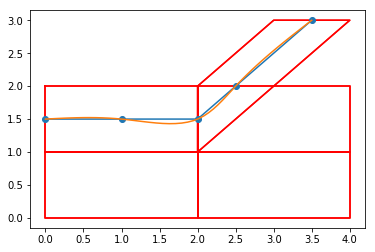

In [19]:
spl_x = make_interp_spline(t, x, bc_type=([(2, 0)], [(2, 0)]))
spl_y = make_interp_spline(t, y, bc_type=([(2, 0)], [(2, 0)]))

for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(spl_x(ts), spl_y(ts))

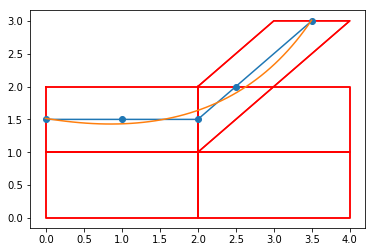

In [20]:
# smoothed spline
s = 1
spl_x = splrep(t, x, s=s)
spl_y = splrep(t, y, s=s)

xs = splev(ts, spl_x)
ys = splev(ts, spl_y)


for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(xs, ys)

In [21]:
spl_x[0]

array([0.        , 0.        , 0.        , 0.        , 4.12132034,
       4.12132034, 4.12132034, 4.12132034])

In [22]:
spl_y[0]

array([0.        , 0.        , 0.        , 0.        , 4.12132034,
       4.12132034, 4.12132034, 4.12132034])

In [23]:
t

array([0.        , 1.        , 2.        , 2.70710678, 4.12132034])

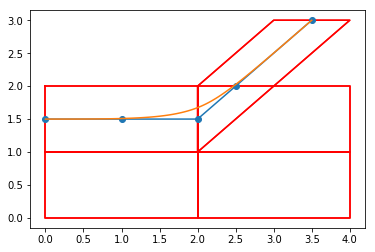

In [24]:
# b spline
l = len(x) 
t2 = np.linspace(0, 1, l - 2, endpoint=True)
t2=np.append([0,0,0],t2)
t2=np.append(t2,[1,1,1])
tck = [t2, [x, y], 3]

u3 = np.linspace(0,1,(max(l*2,70)),endpoint=True)

xs, ys = splev(u3, tck)


for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)
    
plt.plot(x, y, '-o')
plt.plot(xs, ys)

In [25]:
x

(0.0, 1.0, 2.0, 2.5, 3.5)

In [26]:
final_point = path[-1].centerline[-1]
points = [(p.x, p.y) for l in path for p in list(l.centerline)[:-1]] \
         + [(final_point.x, final_point.y)]
points[0] = (0, 1)
x, y = list(zip(*points))

In [27]:
cs_x = CubicSpline(t, x, bc_type=((1, 1), (1, 1)))
cs_y = CubicSpline(t, y, bc_type=((1, 0.5), (1, 1)))

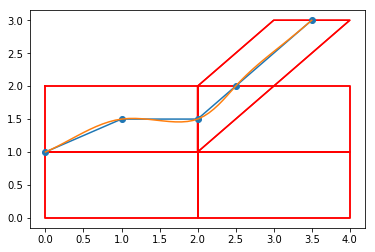

In [28]:
for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(cs_x(ts), cs_y(ts))

In [29]:
ls = LineString(points)

In [30]:
point = Point((4, 5))

In [31]:
ls.project(point)

4.239354332309538

In [32]:
p = ls.interpolate(0.44)

In [33]:
p.x, p.y

(0.39354796403996295, 1.1967739820199814)

In [34]:
ls.distance(p)

4.9650683064945465e-17

In [35]:
result = split(ls, snap(p, ls, 1e-4))

In [36]:
result.wkt

'GEOMETRYCOLLECTION (LINESTRING (0 1, 1 1.5, 2 1.5, 2.5 2, 3.5 3))'

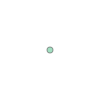

In [37]:
snap(p, ls, 1e-4)

In [38]:
pt = Point((1, 1))
line = LineString([(0,0), (2,2)])
result = split(line, pt)
result.wkt

'GEOMETRYCOLLECTION (LINESTRING (0 0, 1 1), LINESTRING (1 1, 2 2))'

In [39]:
# trim ls to length
current_point = Point((1.5, 1.2))
lat_dist = ls.distance(current_point)
long_dist = ls.project(current_point)
margin = 1

for p in ls.coords:
    if ls.project(Point(p)) > lat_dist + long_dist + margin:
        first_point = Point(p)
        break
else:
    print('no points')
    
# TODO check if first point is the final point

In [40]:
for p in ls.coords:
    print(p)

(0.0, 1.0)
(1.0, 1.5)
(2.0, 1.5)
(2.5, 2.0)
(3.5, 3.0)


In [41]:
ls.coords[-1]

(3.5, 3.0)

In [42]:
first_point.coords[0]

(3.5, 3.0)

In [43]:
split(ls, first_point).wkt

'GEOMETRYCOLLECTION (LINESTRING (0 1, 1 1.5, 2 1.5, 2.5 2, 3.5 3))'

In [44]:
feature_extractor = get_feature_extractor()
frame = Frame(0)
state = AgentState(0, 0.1, 1.5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
frame.add_agent_state(0, state)
config = ManeuverConfig({'termination_point': (3.5, 2.9),
                         'initial_lanelet_id': 2,
                         'final_lanelet_id': 5})
maneuver = FollowLane(feature_extractor, config)

path = maneuver.get_path(0, frame, feature_extractor)


IndexError: too many indices for array

In [ ]:
for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(path[:, 0], path[:, 1])

In [ ]:
a = np.array([1,2,3,4])

In [ ]:
a

In [ ]:
(a[2:] - a[:-2])/2

In [ ]:
a[2:] - 2 * a[1:-1] + a[:-2]

In [ ]:
gamma = np.array(path)
s = np.concatenate(([0], np.cumsum(np.linalg.norm(np.diff(gamma, axis=0), axis=1))))
ds = np.gradient(s).reshape((-1, 1))
d_gamma_ds = np.gradient(gamma, axis=0) / ds
d_2_gamma_ds_2 = np.gradient(d_gamma_ds, axis=0) / ds
kappa = np.linalg.det(np.dstack([d_gamma_ds, d_2_gamma_ds_2])) \
    / np.linalg.norm(d_gamma_ds, axis=1) ** 3

In [ ]:
ds.reshape((1, -1))

In [ ]:
kappa

In [ ]:
plt.plot(kappa)

In [ ]:
plt.plot(path[:,0], path[:,1])

In [ ]:
t

In [ ]:
np.gradient(t)

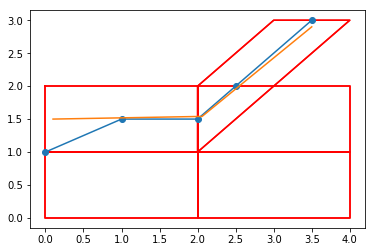

In [45]:
feature_extractor = get_feature_extractor()
frame = Frame(0)
state = AgentState(0, 0.1, 1.5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
frame.add_agent_state(0, state)
config = ManeuverConfig({'termination_point': (3.5, 2.9),
                         'initial_lanelet_id': 2,
                         'final_lanelet_id': 5})
maneuver = FollowLane(feature_extractor, config)

path, velocity = maneuver.get_trajectory(0, frame, feature_extractor)
for l in lanelet_map.laneletLayer:
    LaneletHelpers.plot(l)

plt.plot(x, y, '-o')
plt.plot(path[:, 0], path[:, 1])

In [46]:
velocity

array([4.8357278 , 3.71215073, 4.94611994])

In [ ]:
scenario = Scenario.load('../scenario_config/heckstrasse.json')

In [ ]:
plt.figure(figsize=(12, 8))
scenario.plot()

In [ ]:
feature_extractor = FeatureExtractor(scenario.lanelet_map)

In [ ]:
feature_extractor.routing_graph.getRoute()